In [1]:
from   astropy.io import fits
from astropy.table import Table
import numpy as np
import os
import optparse
import warnings
warnings.filterwarnings('ignore')
from matplotlib.tri import Triangulation, TriAnalyzer
import code
import scipy
import scipy.ndimage as ndimage
from scipy import misc
import glob
from os import path
import matplotlib
import matplotlib.pyplot       as     plt
from   mpl_toolkits.axes_grid1 import AxesGrid
from   matplotlib.ticker       import MultipleLocator, FuncFormatter
from matplotlib import cm

from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

print("****")

****


In [2]:
# indir = "/Users/sande/work/magneticum/i60/"
# # figdir = "/Users/sande/work/magneticum/fig_i60/"

indir = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\MAGNETICUM SIMULATIONS\\'
figdir = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\MAGNEITICUM SIMULATIONS\\IMAGES\\'


In [15]:
# def read_magneticum(file): #read the stellar population results
#     #read age data
#     tab = Table.read(file,format='ascii', header_start = 1)

#     #print(file)
#     #print(tab.colnames)    
#     #print(np.shape(tab))
#     #print(len(tab['bin']))
#     #print(len(tab['vbin[km/s]']))
    
#     stelkin      = np.empty((len(tab['bin']),6))
#     stelkin[:,0] = tab['vbin[km/s]']
#     stelkin[:,1] = tab['sigmabin[km/s]']
#     stelkin[:,2] = tab['mbin[Msun]']
#     stelkin[:,3] = tab['nbin']
#     stelkin[:,4] = tab['xpix[kpc]']
#     stelkin[:,5] = tab['ypix[kpc]']
    
#     return stelkin


In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [4]:
#SLOW
files = glob.glob(indir + '*.dat')

In [5]:
np.shape(files)

(1897,)

In [36]:
files1 = files

In [37]:
%%time
magneticum_maps = []
maxmin = []
for i in range(0, np.size(files1)):
    file = files[i]
    ID = int(files1[i][86:].split('_')[0])
    tab = Table.read(file,format='ascii', header_start = 1)
    
    ybin = tab['ypix[kpc]']
    xbin = tab['xpix[kpc]']
    tab = tab[np.where((np.abs(ybin) < 15) & (np.abs(xbin) < 15))]
    
    stelkin      = np.empty((len(tab['bin']),6))
    stelkin[:,0] = tab['vbin[km/s]']
    stelkin[:,1] = tab['sigmabin[km/s]']
    stelkin[:,2] = tab['mbin[Msun]']
    stelkin[:,3] = tab['nbin']
    stelkin[:,4] = tab['xpix[kpc]']
    stelkin[:,5] = tab['ypix[kpc]']

    pixelsize = np.abs(stelkin[1,4] - stelkin[0,4]) 
    X = stelkin[:,4]
    Y = stelkin[:,5]

    npix = stelkin[:,3]
#     print(np.nanmean(npix))
    vel = stelkin[:,0]
    sig = stelkin[:,1]
    
    # Create image in pixels
    xmin = np.nanmin(X);  xmax = np.nanmax(X)
    ymin = np.nanmin(Y);  ymax = np.nanmax(Y)

    npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
    npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
    i = np.array( np.round( (X - xmin)/pixelsize ), dtype=np.int )
    j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=np.int )
    image = np.full( (npixels_x, npixels_y), np.nan )
    image2 = np.full( (npixels_x, npixels_y), np.nan )
    image[i,j] = vel
    image2[i,j] = sig
    
    vel = image
    sig = image2
    sig1 = sag

    vmin = np.nanmin(vel)        
    vmax = np.nanmax(vel)
    smin = np.nanmin(sig)
    smax = np.nanmax(sig)
    
    maxmin.append([vmin, vmax, smin, smax])
    
    size = np.shape(vel)[0]
    extra = 150-size
#     print(extra)

    if extra < 0:
        vel = vel[:extra,:extra]
        sig = sig[:extra,:extra]
    
    elif extra % 2 == 1:
        emp = np.empty((size,int(extra/2)))
        emp[:] = np.NaN

        emp3 = np.empty((size,int(extra/2)+1))
        emp3[:] = np.NaN

        emp2 = np.empty((int(extra/2)+1,size+extra))
        emp2[:] = np.NaN

        emp4 = np.empty((int(extra/2),size+extra))
        emp4[:] = np.NaN

        vel = np.concatenate((emp, vel, emp3), axis = 1)
        sig = np.concatenate((emp, sig, emp3), axis = 1)

        vel = np.concatenate((emp2, vel, emp4), axis = 0)
        sig = np.concatenate((emp2, sig, emp4), axis = 0)
        
        
        sig = np.nan_to_num(sig, nan = np.nanmin(sig))
        sig = (sig - np.nanmin(sig))/(np.nanmax(sig) - np.nanmin(sig))

        vel = np.nan_to_num(vel, nan = np.nanmean(vel))
#         sig = np.nan_to_num(sig, nan = 0.0) 
        
    elif extra % 2 == 0:
        emp = np.empty((size,int(extra/2)))
        emp[:] = np.NaN

        emp3 = np.empty((size,int(extra/2)))
        emp3[:] = np.NaN

        emp2 = np.empty((int(extra/2),size+extra))
        emp2[:] = np.NaN

        emp4 = np.empty((int(extra/2),size+extra))
        emp4[:] = np.NaN

        vel = np.concatenate((emp, vel, emp3), axis = 1)
        sig = np.concatenate((emp, sig, emp3), axis = 1)

        vel = np.concatenate((emp2, vel, emp4), axis = 0)
        sig = np.concatenate((emp2, sig, emp4), axis = 0)

        vel = np.nan_to_num(vel, nan = np.nanmean(vel)) 
        sig = np.nan_to_num(sig, nan = np.nanmin(sig)) 

    vel = np.rot90(vel)
    sig = np.rot90(sig)
    h, w = vel.shape[:2]
    mask = create_circular_mask(h,w)

    masked_img = vel.copy()
    masked_img[~mask] = np.nanmean(vel)
    
    masked_sig = sig.copy()
    masked_sig[~mask] = np.nanmin(sig)
    
    ratio = 0.2
    result = ndimage.zoom(masked_img, ratio)
    result2 = ndimage.zoom(masked_sig, ratio)
    
    vel = result
    vel = np.nan_to_num(vel, nan = np.nanmean(vel))

    sig = result2
    sig = np.nan_to_num(sig, nan = np.nanmin(sig))
    
    emp = np.empty((30,10))
    emp[:] = np.NaN

    emp2 = np.empty((10,50))
    emp2[:] = np.NaN

    vel = np.concatenate((emp, vel, emp), axis = 1)
    sig = np.concatenate((emp, sig, emp), axis = 1)

    vel = np.concatenate((emp2, vel, emp2), axis = 0)
    sig = np.concatenate((emp2, sig, emp2), axis = 0)

#     vel = np.nan_to_num(vel, nan = 0.5)
    vel = (vel - np.nanmin(vel))/(np.nanmax(vel) - np.nanmin(vel))
    vel = np.nan_to_num(vel, nan = np.nanmean(vel))
   
    sig = (sig - np.nanmin(sig))/(np.nanmax(sig) - np.nanmin(sig))
    sig = np.nan_to_num(sig, nan = np.nanmin(sig))

    
    magneticum_maps.append([vel, sig, ID])
    
    


Wall time: 1h 16min 25s


In [9]:
maxmin1 = np.array(maxmin)
vmin = maxmin1[:,0]
vmax = maxmin1[:,1]
smin = maxmin1[:,2]
smax = maxmin1[:,3]

In [10]:
h

150

In [11]:
w

150

In [39]:
np.shape(magneticum_maps)

(1897, 3)

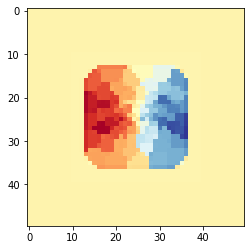

In [34]:
plt.imshow(magneticum_maps[40][0], cmap = 'RdYlBu_r')
# plt.colorbar()



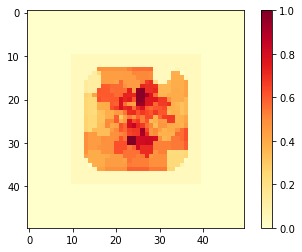

In [35]:
plt.imshow(magneticum_maps[40][1], cmap = 'YlOrRd')
plt.colorbar()

In [38]:
magneticum_maps[0][0][20]

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.53847311, 0.55427683, 0.60067777, 0.64103826, 0.5425678 ,
       0.55222561, 0.55008187, 0.45331389, 0.4800583 , 0.53483587,
       0.4977543 , 0.56953824, 0.45230884, 0.54764201, 0.57321636,
       0.63062926, 0.66010239, 0.65896102, 0.70049837, 0.76678476,
       0.66694149, 0.78170916, 0.79367096, 0.82308388, 0.69925319,
       0.80972484, 0.80560721, 0.69121145, 0.74238249, 0.53847306,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

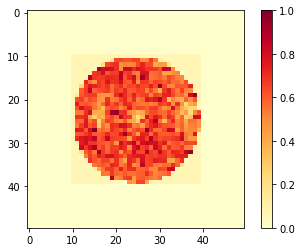

In [40]:
plt.imshow(magneticum_maps[1][1], cmap = 'YlOrRd')
plt.colorbar()

(array([1666., 2462., 1802., 3567., 2019., 1979.,  463.,  404.,    0.,
          38.]),
 array([ 63. ,  74.1,  85.2,  96.3, 107.4, 118.5, 129.6, 140.7, 151.8,
        162.9, 174. ]),
 <BarContainer object of 10 artists>)

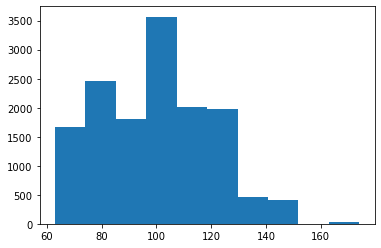

In [42]:
pix1 = magneticum_maps[3][3]
plt.hist(pix1)

In [43]:
count = 0
for i in pix1:
    if i > 75:
        count = count+1
        
count/np.size(pix1)

0.8438888888888889

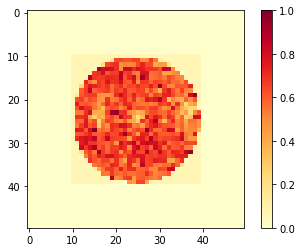

In [31]:
rrr = magneticum_maps[1][1]
plt.imshow(rrr, cmap = 'YlOrRd')
plt.colorbar()

In [27]:
ID

10056

In [32]:
np.shape(magneticum_maps)

(500, 3)

In [41]:
X = []
X1 = []
# Y = []
Z = []


for maps, sigmaps, catids, in magneticum_maps:
    X.append(maps)
    X1.append(sigmaps)
#     Y.append(labels)
    Z.append(catids)

X = np.array(X).reshape(-1, 50,50, 1)
X1 = np.array(X1).reshape(-1, 50,50, 1)
# Y = np.array(Y)
Z = np.array(Z)

In [42]:
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\vel_mag_271021', X)
X1_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\sig_mag_271021', X1)
# Y_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\label_voranoid_210721', Y)
Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\catid_mag_271021', Z)

In [69]:
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\mag_vmin_051021', vmin)
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\mag_vmax_051021', vmax)
Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\mag_smin_051021', smin)
Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\mag_smax_051021', smax)

# Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\EAGLE_ellip60_140921', ellip)
# Z_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\EAGLE_lambdar60_140921', lambdar)


In [85]:
np.shape(magneticum_maps[1][1])

(50, 50)

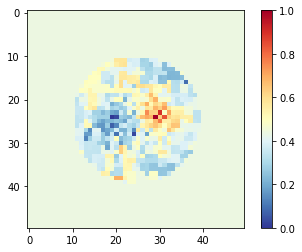

In [12]:
vel11 = magneticum_maps[2][0]
plt.imshow(vel11, cmap = "RdYlBu_r")
plt.colorbar()

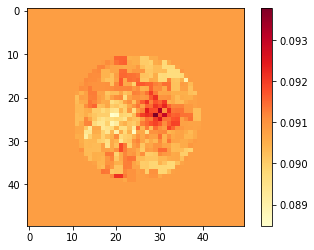

In [13]:
vel11 = magneticum_maps[2][1]
plt.imshow(vel11, cmap = "YlOrRd")
plt.colorbar()

## X bin and Y-bin < 15 - then reshape or zoom

In [150]:
ybin = tab['ypix[kpc]']
tab = tab[np.where(np.abs(ybin) < 15)]
xbin = tab['xpix[kpc]']
tab = tab[np.where(np.abs(xbin) < 15)]

In [10]:
npix = tab['npix']

In [16]:
stelkin      = np.empty((len(tab['bin']),6))
stelkin[:,0] = tab['vbin[km/s]']
stelkin[:,1] = tab['sigmabin[km/s]']
stelkin[:,2] = tab['mbin[Msun]']
stelkin[:,3] = tab['nbin']
stelkin[:,4] = tab['xpix[kpc]']
stelkin[:,5] = tab['ypix[kpc]']

## Create array to calculate every magnetiucm map

0.1992560000000001


<Figure size 432x288 with 0 Axes>

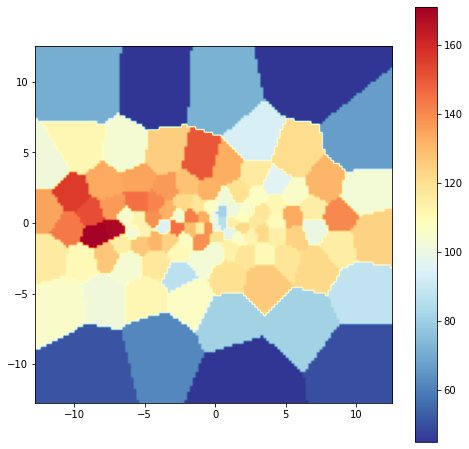

In [20]:
fig = plt.figure()

fig, ax_array = plt.subplots(squeeze=False,figsize=(8,8))

pixelsize = np.abs(stelkin[1,4] - stelkin[0,4]) 
print(pixelsize)
X = stelkin[:,4]
Y = stelkin[:,5]

npix = stelkin[:,3]
val = stelkin[:,0]

vmin = np.nanmin(val)        
vmax = np.nanmax(val)

# val = np.where(npix > 1, val, np.NaN)

# median = np.nanmedian
# val = (val - np.nanmin(val))/(np.nanmax(val) - np.nanmin(val))
# val = np.nan_to_num(val, nan = 0.5) 

# Create image in pixels
xmin = np.nanmin(X);  xmax = np.nanmax(X)
ymin = np.nanmin(Y);  ymax = np.nanmax(Y)

npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
i = np.array( np.round( (X - xmin)/pixelsize ), dtype=np.int )
j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=np.int )
image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = val

tmp = plt.imshow(np.rot90(image), cmap='RdYlBu_r', interpolation=None, vmin=vmin, vmax=vmax, \
                extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )

plt.colorbar()
plt.show()

In [155]:
vel = np.rot90(image)
h, w = vel.shape[:2]
mask = create_circular_mask(h,w)

masked_img = vel.copy()
masked_img[~mask] = 0.5

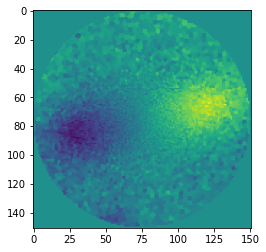

In [156]:
plt.imshow(masked_img)

In [139]:
vel = image

size = np.shape(image)[0]
extra = 150-size

emp = np.empty((size,int(extra/2)))
emp[:] = np.NaN

emp3 = np.empty((size,int(extra/2)+1))
emp3[:] = np.NaN

emp2 = np.empty((int(extra/2)+1,size+extra))
emp2[:] = np.NaN

emp4 = np.empty((int(extra/2),size+extra))
emp4[:] = np.NaN


vel = np.concatenate((emp, vel, emp3), axis = 1)
# sig = np.concatenate((emp, sig, emp), axis = 1)

vel = np.concatenate((emp2, vel, emp4), axis = 0)
# sig = np.concatenate((emp2, sig, emp2), axis = 0)

# vel = np.nan_to_num(vel, nan = 0.5)
# # vel = (vel - np.nanmin(vel))/(np.nanmax(vel) - np.nanmin(vel))
vel = np.nan_to_num(vel, nan = 0.5) 


In [118]:
np.shape(vel)

(150, 150)

In [103]:
ratio = (30/np.shape(vel)[0])

In [104]:
ratio

0.2

In [161]:
vel = masked_img

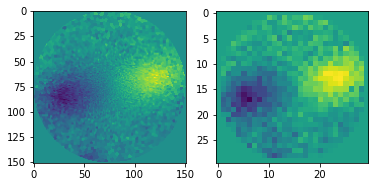

In [162]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = vel
result = ndimage.zoom(vel, ratio)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()

In [158]:
np.shape(result)

(30, 30)

In [163]:
vel = result
vel = np.nan_to_num(vel, nan = 0.5)

emp = np.empty((30,10))
emp[:] = np.NaN

emp2 = np.empty((10,50))
emp2[:] = np.NaN

vel = np.concatenate((emp, vel, emp), axis = 1)
# sig = np.concatenate((emp, sig, emp), axis = 1)

vel = np.concatenate((emp2, vel, emp2), axis = 0)
# sig = np.concatenate((emp2, sig, emp2), axis = 0)

vel = np.nan_to_num(vel, nan = 0.5)
# vel = (vel - np.nanmin(vel))/(np.nanmax(vel) - np.nanmin(vel))
# vel = np.nan_to_num(vel, nan = 0.5) 


In [126]:
vel = np.nan_to_num(vel, nan = 0.5) 

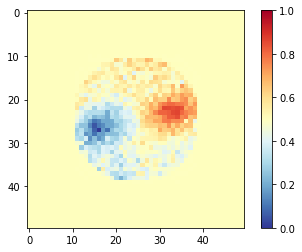

In [164]:
plt.imshow(vel, cmap = "RdYlBu_r", vmin = 0, vmax = 1)
plt.colorbar()

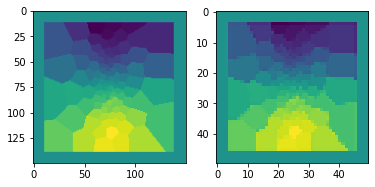

In [87]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = vel
result = ndimage.zoom(vel, 1/3)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()

In [88]:
np.shape(result)

(50, 50)

In [88]:
np.nanmax(vel)

0.8663925685754112

In [126]:
tab1 = Table.read(files[2],format='ascii', header_start = 1)

In [113]:
tab1

bin,xbin[kpc],ybin[kpc],vbin[km/s],sigmabin[km/s],nbin,mbin[Msun],xpix[kpc],ypix[kpc],vpix[km/s],sigmapix[km/s],npix,mpix[Msun]
int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,int32,float64
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-15.241552,-15.241552,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-15.041006,-15.241552,64.320175,0.0,1,1603610.8
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.840459,-15.241552,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.639912,-15.241552,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.439365,-15.241552,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.238819,-15.241552,-154.21082,0.0,1,1650869.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.038272,-15.241552,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-13.837725,-15.241552,-133.22964,0.0,1,1581038.2
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-13.637178,-15.241552,0.0,0.0,0,0.0


In [114]:
ybin = tab1['ypix[kpc]']
tab1 = tab1[np.where(np.abs(ybin) < 15)]
xbin = tab1['xpix[kpc]']
tab1 = tab1[np.where(np.abs(xbin) < 15)]

In [19]:
stelkin      = np.empty((len(tab1['bin']),6))
stelkin[:,0] = tab1['vbin[km/s]']
stelkin[:,1] = tab1['sigmabin[km/s]']
stelkin[:,2] = tab1['mbin[Msun]']
stelkin[:,3] = tab1['npix']
stelkin[:,4] = tab1['xpix[kpc]']
stelkin[:,5] = tab1['ypix[kpc]']

NameError: name 'tab1' is not defined

In [116]:
tab1

bin,xbin[kpc],ybin[kpc],vbin[km/s],sigmabin[km/s],nbin,mbin[Msun],xpix[kpc],ypix[kpc],vpix[km/s],sigmapix[km/s],npix,mpix[Msun]
int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,int32,float64
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.840459,-14.840459,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.639912,-14.840459,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.439365,-14.840459,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.238819,-14.840459,-79.07626,0.0,1,1632634.6
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-14.038272,-14.840459,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-13.837725,-14.840459,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-13.637178,-14.840459,0.0,0.0,0,0.0
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-13.436632,-14.840459,-13.571746,0.0,1,1683892.6
569,-12.789507,-14.04861,-13.318004,104.79725,75,131555280.0,-13.236085,-14.840459,131.29514,0.0,1,1970715.9


0.12011250000000029


<Figure size 432x288 with 0 Axes>

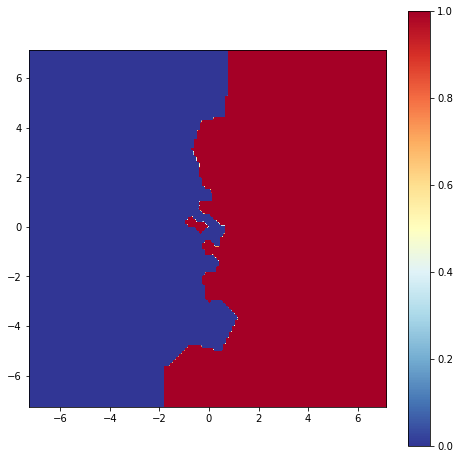

In [14]:
fig = plt.figure()

fig, ax_array = plt.subplots(squeeze=False,figsize=(8,8))

pixelsize = np.abs(stelkin[1,4] - stelkin[0,4]) 
print(pixelsize)
X = stelkin[:,4]
Y = stelkin[:,5]

npix = stelkin[:,3]

val = stelkin[:,0]

# vmin = np.nanmin(val)        
# vmax = np.nanmax(val)

# # val = np.where(npix > 25, val, np.NaN)

# # median = np.nanmedian(val)
# # val = (val - np.nanmin(val))/(np.nanmax(val) - np.nanmin(val))
# # val = np.nan_to_num(val, nan = 0.5) 

# # Create image in pixels
# xmin = np.nanmin(X);  xmax = np.nanmax(X)
# ymin = np.nanmin(Y);  ymax = np.nanmax(Y)

# npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
# npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
# i = np.array( np.round( (X - xmin)/pixelsize ), dtype=np.int )
# j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=np.int )
# image = np.full( (npixels_x, npixels_y), np.nan )
# image[i,j] = val

# tmp = plt.imshow(np.rot90(image), cmap='RdYlBu_r', interpolation=None, vmin=0, vmax=1, \
#                 extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )

# plt.colorbar()
# plt.show()

vmin = np.nanmin(val)        
vmax = np.nanmax(val)
# Create image in pixels
xmin = np.nanmin(X);  xmax = np.nanmax(X)
ymin = np.nanmin(Y);  ymax = np.nanmax(Y)

npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
i = np.array( np.round( (X - xmin)/pixelsize ), dtype=np.int )
j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=np.int )
image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = val

cmap_array = ['inferno','RdYlBu_r','YlOrRd']
tmp = axes.imshow(np.rot90(image), cmap=cmap_array[fi%3], interpolation=None, vmin=vmin, vmax=vmax, \
        extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] 

['C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\MAGNETICUM SIMULATIONS\\velmap_0_60deg.dat', 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\MAGNETICUM SIMULATIONS\\velmap_10053_60deg.dat', 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\MAGNETICUM SIMULATIONS\\velmap_10054_60deg.dat']


<Figure size 432x288 with 0 Axes>

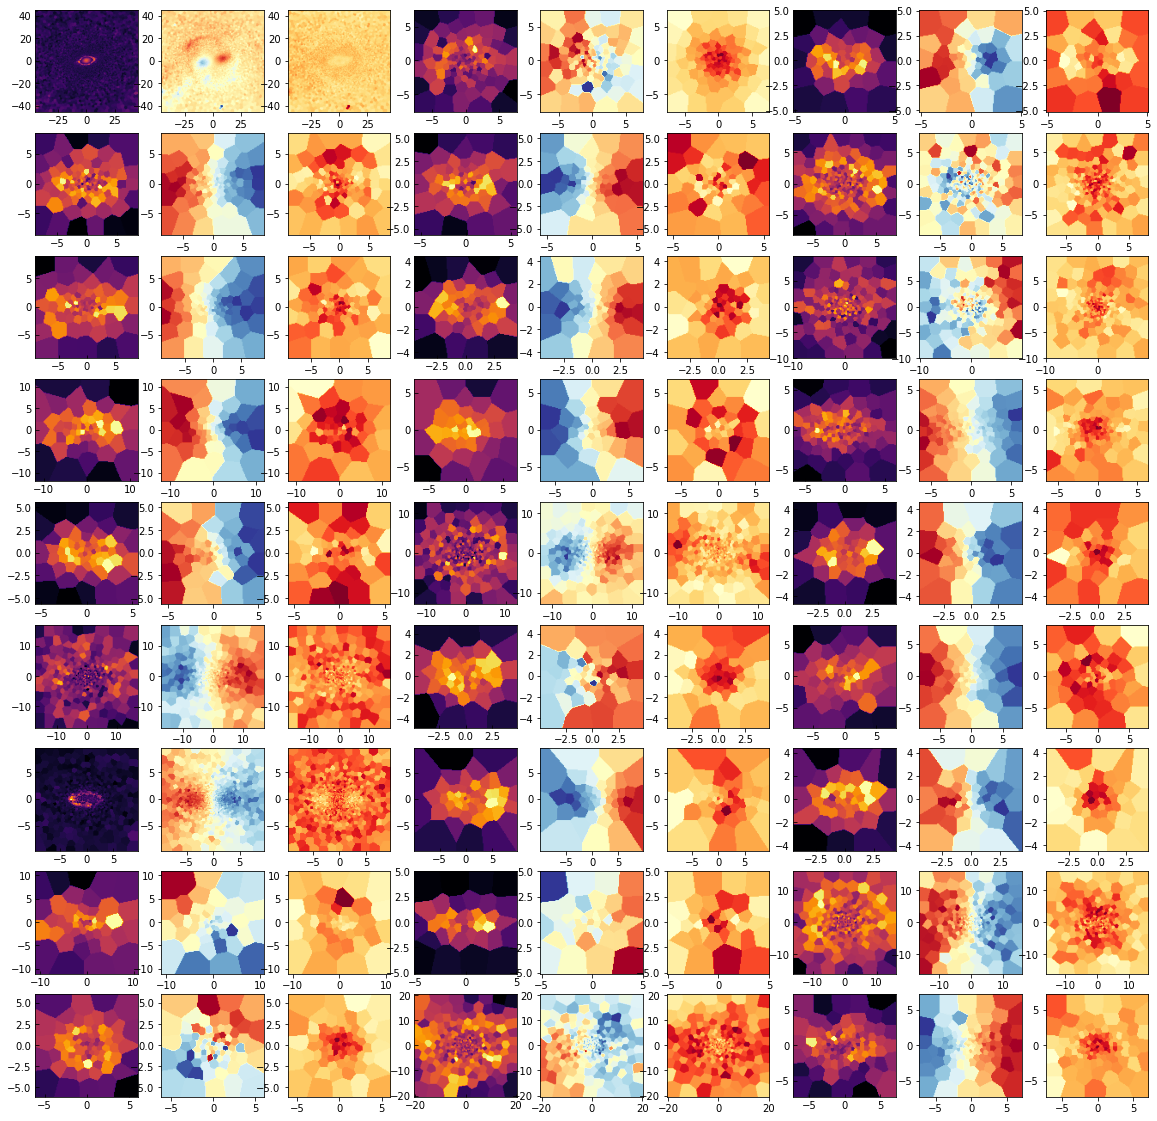

In [12]:
files = glob.glob(indir + '*.dat')
print(files[0:3])

fig = plt.figure()

columns = 9
rows = 9
fi = 0

fig, ax_array = plt.subplots(rows, columns,squeeze=False,figsize=(20,20))
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        #axes.set_title('{},{}'.format(i,j))
        #axes.set_yticklabels([])
        #axes.set_xticklabels([])
 
        if fi%3 == 0:
            file = files[fi]
            stelkin = read_magneticum(file)

            axes.tick_params(direction='in')

            # Create image in pixels
            X = stelkin[:,4]
            Y = stelkin[:,5]
            pixelsize = np.abs(stelkin[1,4] - stelkin[0,4])  #how does this work and how do I force it to fit to SAMI
            val = stelkin[:,2]
        if fi%3 == 1:
            val = stelkin[:,0]
        if fi%3 == 2:
            val = stelkin[:,1]

        vmin = np.nanmin(val)        
        vmax = np.nanmax(val)
        # Create image in pixels
        xmin = np.nanmin(X);  xmax = np.nanmax(X)
        ymin = np.nanmin(Y);  ymax = np.nanmax(Y)

        npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
        npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
        i = np.array( np.round( (X - xmin)/pixelsize ), dtype=np.int )
        j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=np.int )
        image = np.full( (npixels_x, npixels_y), np.nan )
        image[i,j] = val

        cmap_array = ['inferno','RdYlBu_r','YlOrRd']
        tmp = axes.imshow(np.rot90(image), cmap=cmap_array[fi%3], interpolation=None, vmin=vmin, vmax=vmax, \
                extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
        
        fi += 1
        
# plt.savefig(figdir+'jh_magneticum_sim_maps.pdf', bbox_inches='tight', pad_inches=0.3)
        
plt.show()

2
